# Computing 3

...run the next cell with Shift + Enter...

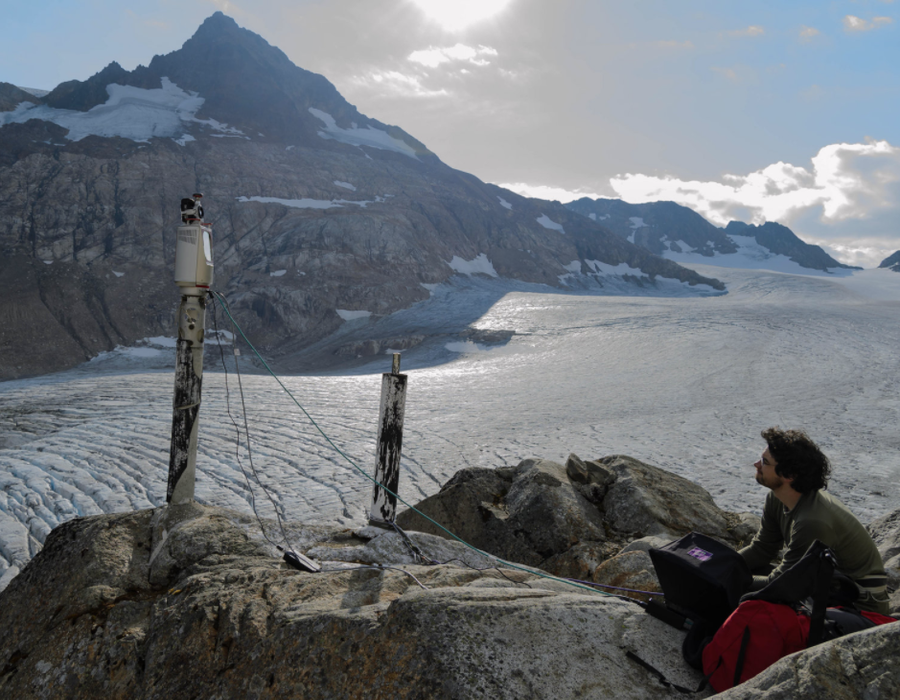

In [1]:
import kilroy
kilroy.Show('landscape','David_Shean_using_UW_terrestrial_laser_scanner_at_South_Cascade_Glacier.png', 900,700)

*WARNING!!! Skill with mathematics can backfire and land you in peril. Fortunately
Professor David Shean escaped from this rocky perch after he placed some equipment to watch over the glacier.
(He was rescued by eagles.)*


### Friendly introduction


Why is there a picture of Professor Shean sitting on some rocks up above? This is a notebook
about computing after all, not rock climbing. But allow me to explain. First Professor Shean has a knack for 
getting into these situations. He works in remote locations involving snow and ice. Some of his work involves 
collecting *data* (mostly numbers) and converting that to *information*. Then he writes papers describing
his results and conclusions; and he shares his data with other scientists.


Let's take a look at some earth science data. We'll leave glaciers for another time... our goal on this
page is to look at some ocean data. We will do that using Python tools.


As you explore this page remember: You can back up and read things again; and you can skip down and 
read ahead. This may help if things do not quite make sense right away.

## Glodap data exploration

> The code here is intended to *work* and to *show* how code is built. It is not intended to *teach* someone
> how to work in Python. That is a more involved process and you can talk to the club guides about how to 
> do that if you are interested.


We want to work with some ocean data from a project called **glodap**. You can 
[read about this project on Wikipedia](https://en.wikipedia.org/wiki/Global_Ocean_Data_Analysis_Project).
This will require running a sequence of Python cells in order, below. Each one has a short summary
narrative.


### To begin we install some software


The next cell installs two software packages that are used by Python to work with large datasets. It
takes about a minute to run. 


By the way a *dataset* is a lot of data in the form of numbers together
with information *about* those numbers.


Run the cell below.

In [2]:
# Get version of Python
import sys
sys.version
sys.version_info

sys.version_info(major=2, minor=7, micro=14, releaselevel='final', serial=0)

In [1]:
# This cell must run first
!conda install netcdf4 -y

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /home/nbcommon/anaconda2_501:

The following NEW packages will be INSTALLED:

    netcdf4:   1.3.1-py27hca9ce0b_2            

The following packages will be UPDATED:

    conda:     4.3.29-py27_0        conda-forge --> 4.4.6-py27_0        
    conda-env: 2.6.0-0              conda-forge --> 2.6.0-h36134e3_1    
    pycosat:   0.6.2-py27h1cf261c_1             --> 0.6.3-py27ha4109ae_0

conda-env-2.6. 100% |################################| Time: 0:00:00   1.89 MB/s
pycosat-0.6.3- 100% |################################| Time: 0:00:00   6.64 MB/s
netcdf4-1.3.1- 100% |################################| Time: 0:00:00  22.55 MB/s###############               | Time: 0:00:00  21.19 MB/s
conda-4.4.6-py 100% |################################| Time: 0:00:00  28.90 MB/s##     | Time: 0:00:00  27.30 MB/s


In [2]:
!touch /home/nbuser/.conda/environments.txt
!chmod a+w /home/nbuser/.conda/environments.txt
!conda install xarray -y 

Solving environment: done

## Package Plan ##

  environment location: /home/nbcommon/anaconda2_501

  added / updated specs: 
    - xarray


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    xarray-0.10.0              |   py27hd0a7aca_0         558 KB
    certifi-2017.11.5          |   py27h71e7faf_0         196 KB
    ------------------------------------------------------------
                                           Total:         754 KB

The following NEW packages will be INSTALLED:

    xarray:  0.10.0-py27hd0a7aca_0     

The following packages will be UPDATED:

    certifi: 2017.7.27.1-py27h9ceb091_0 --> 2017.11.5-py27h71e7faf_0


xarray 0.10.0: ######################################################### | 100% 
certifi 2017.11.5: ##################################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


### Import some tools

Python has powerful tools available. To use them we need to issue some *import* commands. It is very much
like Python is the body of an airplane... and we are sitting at the controls... but if we want to fly we 
need to import two wings and a tail and an engine and some wheels. That's what we do next. 


If the cell below produces an error message: It may be that the 
cell above did not run properly. You might need to go run that one again.

Run the cell below.

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import boto
from boto.s3.key import Key
import xarray as xr

### More getting ready

This cell does a bit more preparation so you should run it.

In [4]:
# This cell copies a glodap salinity file to the local directory, naming it 'glodap_salinity.nc'
connection = boto.connect_s3(anon=True)
bucket = connection.get_bucket('himatdata')

for key in bucket.list(): 
    filename = key.name.encode('utf-8')
    if 'glodap' in filename:
        if 'salinity.nc' in filename: 
            print 'salinity file is', filename
            salinityfilename = filename
        if 'temperature.nc' in filename: 
            print 'temperature file is', filename
            temperaturefilename = filename
        if 'oxygen.nc' in filename: 
            print 'oxygen file is', filename
            oxygenfilename = filename            

local_salinity_filename = 'glodap_salinity.nc'
local_temperature_filename = 'glodap_temperature.nc'
local_oxygen_filename = 'glodap_oxygen.nc'

oxygen file is glodap/GLODAPv2.2016b.oxygen.nc
salinity file is glodap/GLODAPv2.2016b.salinity.nc
temperature file is glodap/GLODAPv2.2016b.temperature.nc


### Check if our data is present


We want to look at the world's oceans: oxygen levels, how saline (salty) the water is, and what the temperature
of the water is. We can immediately ask questions like 'What can hold more oxygen: cold water or warm water?'


By the way it is important to realize that gasses can dissolve in water. In this case we are interested in 
how much oxygen is dissolved in the water; that is what fishes breathe. You are familiar with soda being fizzy;
and this is due to having lots of carbon dioxide dissolved in the water. There is a lot of carbon dioxide 
dissolved in the ocean but we won't look at that here. 


There are three data files we will use for oxygen, salinity and temperature. 
Either they are already here on this computer or they are not. If not we will have to go get 
them from 'the cloud'. The cloud is just a computer somewhere else.


The data files are pretty big and there are three of them. Each one is 100 million bytes of data. 
Let's see if they are here. Run the cell below and if it produces three lines like this: 

`
-rw-r--r-- 1 nbuser nbuser 102664419 Dec  1 03:21 glodap_oxygen.nc
-rw-r--r-- 1 nbuser nbuser 102664370 Dec  1 03:21 glodap_salinity.nc
-rw-r--r-- 1 nbuser nbuser 102664315 Dec  1 03:21 glodap_temperature.nc
`

then we can continue, skipping the Python cell after that. 

In [5]:
!ls -al *.nc

-rw-r--r-- 1 nbuser nbuser 102664419 Dec  2 20:30 glodap_oxygen.nc
-rw-r--r-- 1 nbuser nbuser 102664370 Dec  2 20:30 glodap_salinity.nc
-rw-r--r-- 1 nbuser nbuser 102664315 Dec  2 20:30 glodap_temperature.nc


### Get the data if necessary

If these three files were listed when you ran the previous cell: Skip the next cell. 


If they were not present: Run this next cell. 
It should go get all three data files. It will take a minute or so. If this works the files will
be listed below the cell when it is done.

In [56]:
k = Key(bucket)
k.key = salinityfilename
k.get_contents_to_filename(local_salinity_filename)
k.key = temperaturefilename
k.get_contents_to_filename(local_temperature_filename)
k.key = oxygenfilename
k.get_contents_to_filename(local_oxygen_filename)

# If this works you should see three 100MByte files listed
!ls -al glodap_*.nc

-rw-r--r-- 1 nbuser nbuser 102664419 Dec  2 20:30 glodap_oxygen.nc
-rw-r--r-- 1 nbuser nbuser 102664370 Dec  2 20:30 glodap_salinity.nc
-rw-r--r-- 1 nbuser nbuser 102664315 Dec  2 20:30 glodap_temperature.nc


### Almost there

We are almost to the point where we can look at the data. The next step is to create three dataset objects in
Python that connect to our data files.


Run this cell; it should go quickly and print a lot of text below.

In [6]:
dsSal = xr.open_mfdataset(local_salinity_filename)
dsTemp = xr.open_mfdataset(local_temperature_filename)
dsO2 = xr.open_mfdataset(local_oxygen_filename)
dsO2          # This prints the structure of the oxygen dataset below

<xarray.Dataset>
Dimensions:        (depth_surface: 33, lat: 180, lon: 360, snr: 1)
Coordinates:
  * lon            (lon) float64 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5 ...
  * lat            (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
Dimensions without coordinates: depth_surface, snr
Data variables:
    oxygen         (depth_surface, lat, lon) float64 dask.array<shape=(33, 180, 360), chunksize=(33, 180, 360)>
    oxygen_error   (depth_surface, lat, lon) float64 dask.array<shape=(33, 180, 360), chunksize=(33, 180, 360)>
    Input_mean     (depth_surface, lat, lon) float64 dask.array<shape=(33, 180, 360), chunksize=(33, 180, 360)>
    Input_std      (depth_surface, lat, lon) float64 dask.array<shape=(33, 180, 360), chunksize=(33, 180, 360)>
    Input_N        (depth_surface, lat, lon) float64 dask.array<shape=(33, 180, 360), chunksize=(33, 180, 360)>
    oxygen_relerr  (depth_surface, lat, lon) float64 dask.array<shape=(33, 180, 360), chunksize=(33, 180, 360)>
    SnR 

### Ready to go

Skim the information printed above. That is an example of 'information about the data'. It describes
what data are present in the oxygen dataset. It even mentions the email address of the scientist
responsible for this data. 

The important thing about this dataset is that it represents just one snapshot in time: How much 
oxygen is dissolved in the world ocean. (That is all of the oceans combined into one big picture.)


The next cell will print some oxygen information; and there is a little background that may
interest you:

An oxygen molecule is called $O_2$ because it is two oxygen atoms stuck together.
One oxygen atom weighs 16 on a scale where hydrogen weighs 1. This means that an
oxygen *molecule* of two oxygen atoms weighs 32. An interesting fact of chemistry is
that if we have this many *grams* of oxygen--that is 32 grams--we will have 
$6 \times 10^{23}$ oxygen molecules. This is called a *mole* of molecular oxygen. One
mole of something is $6 \times 10^{23}$ copies of that thing. 


Our map will display how much oxygen is dissolved in the water in units of micro-moles. 
A micro mole is one millionth of a mole or $6 \times 10^{23}$ of that thing, in our case
molecular oxygen. This oxygen is dissolved in ocean water. If it was not there life in the
ocean would instantly suffocate. How does it get there? Partly by contact with the
atmosphere but much more importantly due to the constant activity of algae near the ocean
surface. This algae uses sunlight to create sugar from water and dissolved carbon 
dioxide; and the same algae exhales oxygen in the process. 


This is a lot to take in and I mention it just out of interest. The main thing to bear in
mind is that oxygen is dissolved in the ocean and now we are ready to look at that. 


Go ahead and run the next cell.

In [7]:
dsO2['oxygen'][0:2,50:52,170:172].values   # a few dissolved oxygen values near the surface

array([[[ 238.48782349,  238.15356445],
        [ 234.73210144,  233.86155701]],

       [[ 238.48214722,  238.13267517],
        [ 234.77105713,  233.89480591]]])

The previous cell shows getting actual dissolved oxygen numbers from the dataset; eight of 
them.


Now please run the cell below to see all of the data. Play with the slider above the chart and
determine how that changes what you see.

In [8]:
from ipywidgets import *
from traitlets import dlink
def plotOxygen(depth_index):
    a=dsO2['oxygen'].sel(depth_surface = depth_index)
    a.plot(figsize=(16, 10),cmap=plt.cm.bwr,vmin=150, vmax=350)
    msg = 'This is for '
    if depth_index == 0: msg += 'surface water'
    else: msg += 'water at ' + str(int(dsO2['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg, fontsize = '20')
    plt.text(28, 50, 'oxygen dissolved in', fontsize = '20')
    plt.text(28, 42, '     ocean water   ', fontsize = '20')
    
interact(plotOxygen, depth_index=widgets.IntSlider(min=0,max=32,step=1,value=0, continuous_update=False))

A Jupyter Widget

<function __main__.plotOxygen>

In the map above the colors represent oxygen dissolved 
in ocean surface waters... but you can explore deeper depths of the ocean by moving the slider 
located just above the map. Play around with this before answering the questions. Each time you move 
the slider the new depth will be printed on the map at the lower left.

<br>
<br>

The questions that follow concern the map shown above. They are not important except for two things. 
You might say 'If they are not important questions then why are you asking them???' Good point. I 
write 'not important' to emphasize that *you* own the important ideas here. The questions show you 
*what sort of questions can be asked*; that's the first value they have. The questions help you
get a handle on how the map and the control and the color scheme work together; that's the second
value. Ok so here we go...

<br>${\Huge \infty}$

- What are the sharp pure-white regions? For example those surrounding the central colored region?
- What is the name of the central colored region?
- Does blue water have a *lot* or a *small amount* of oxygen?
- Which has more oxygen: Blue water or 'cloudy white' water? 
- Which has more oxygen: Cloudy white water or red water?
- How would you generally describe the regions where you would find oxygen-rich surface waters?
- Make a guess: How does oxygen in water relate to temperature of water?
- Would you guess that water temperature tends to affect dissolved oxygen or dissolved oxygen tends to affect temperature?
- What happens at the equator to the oxygen levels as you dive deeper and deeper? 
- Why do the oceans appear to shrink when you set the slider value deeper and deeper?


<br>${\Huge \infty}$


- **This is the important problem: Please write down at least three questions of your own. 
Better would be to write down five or six. They should be based on what you see in the data 
that you find interesting; or perhaps questions the data suggests but does not answer.**

<br>
<br>
### Salinity

Now we move on to salinity, the *saltiness* of the water. The Latin root for salt is $salis$. You know ocean water 
is salty; but *how* salty it? This is is something we can measure. It varies from place to place. It also varies with 
depth. 


<br>${\Huge \infty}$

Before you look this next map make a guess: Does the ocean get saltier or less salty as you go down from
the surface?



In [13]:
def plotSalinity(depth_index):
    b = dsSal['salinity'].sel(depth_surface = depth_index)
    b.plot(figsize=(16, 10),cmap=plt.cm.bwr,vmin=33, vmax=36)
    msg = 'This is for '
    if depth_index == 0: msg += 'surface water'
    else: msg += 'water at ' + str(int(dsO2['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg, fontsize = '20')
    plt.text(47, 50, 'salinity of', fontsize = '20')
    plt.text(47, 42, 'ocean water', fontsize = '20')
    
interact(plotSalinity, depth_index=widgets.IntSlider(min=0,max=32,step=1,value=0, continuous_update=False))

A Jupyter Widget

<function __main__.plotSalinity>

<br>${\Huge \infty}$

There is a subtle blue feature on the northeast coast of South America. What do you imagine might
be the cause? (There is a similar but smaller feature on the west coast of Africa.)




<br>${\Huge \infty}$

As above with oxygen: Write down three or more questions based on your exploration of these data.


### Temperature

In [14]:
def plotTemperature(depth_index):
    c=dsTemp['temperature'].sel(depth_surface = depth_index)
    c.plot(figsize=(16, 10),cmap=plt.cm.bwr,vmin=0, vmax=23)
    msg = 'This is for '
    if depth_index == 0: msg += 'surface water'
    else: msg += 'water at ' + str(int(dsO2['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg, fontsize = '20')
    plt.text(47, 50, 'temperature of', fontsize = '20')
    plt.text(47, 42, 'ocean water', fontsize = '20')

interact(plotTemperature, depth_index=widgets.IntSlider(min=0,max=32,step=1,value=0, continuous_update=False))   

A Jupyter Widget

<function __main__.plotTemperature>

<br>${\Huge \infty}$

Now that you have all three data sources (temperature, salinity, dissolved oxygen): Come up with some 
questions that connect them together. This activity you could do in five or ten minutes. Some people
(like the author) would need a couple of hours just to get started on this task.

### What are the depths?


This is just a little detail on how the results above were produced. 


The slider controls for the map choose depth... but on a scale of 0 to 32. When the map
shows up the actual depth is printed at the lower left. This is how the number 10
is converted to the correct depth for that. Then I show all 33 depth values.

In [11]:
print dsTemp['Depth'].values[10]
print '    '
print dsTemp['Depth'].values

250.0
    
[    0.    10.    20.    30.    50.    75.   100.   125.   150.   200.
   250.   300.   400.   500.   600.   700.   800.   900.  1000.  1100.
  1200.  1300.  1400.  1500.  1750.  2000.  2500.  3000.  3500.  4000.
  4500.  5000.  5500.]


# Stop here

### Below here is some source material, not organized yet
### It does not involve data science; it is a different topic

Begin with a row of cells. (The code below says 'ncells = 1000'.) A particular cell is at position $i$. The cell to the 
left is at $i-1$. The cell to the right is at $i+1$. These three cells in a row are $L\; M\; R$ for 
Left Middle Right.

There is a rule that examines cells L, M, and R to give a new result at cell $i$ (which is the middle cell M) for the 
row (or the next time step). This rule is applied across the entire row of cells at once; so no changes are made 
until everything is determined.

We imagine that the cells loop around as a ring so the L cell for $i=0$ is cell $ncells-1$ (at the far right) and
the R cell for cell $ncells-1$ is cell $0$.

You can change the rule by changing the sequence of ones and zeros in the parentheses. Then run the CA and see what your rule produces. Rules you may find interesting: 30, 90, 110, 184. Be sure to try rules with both a single seed and with a 
random pattern as the seed: You set the randomPattern variable to either True or False.

Populating the interactive namespace from numpy and matplotlib
501718
[1120801, 125235, 126890, 125356, 125235, 127011, 125356, 124116]
[0, 1, 1, 1, 1, 0, 0, 0]


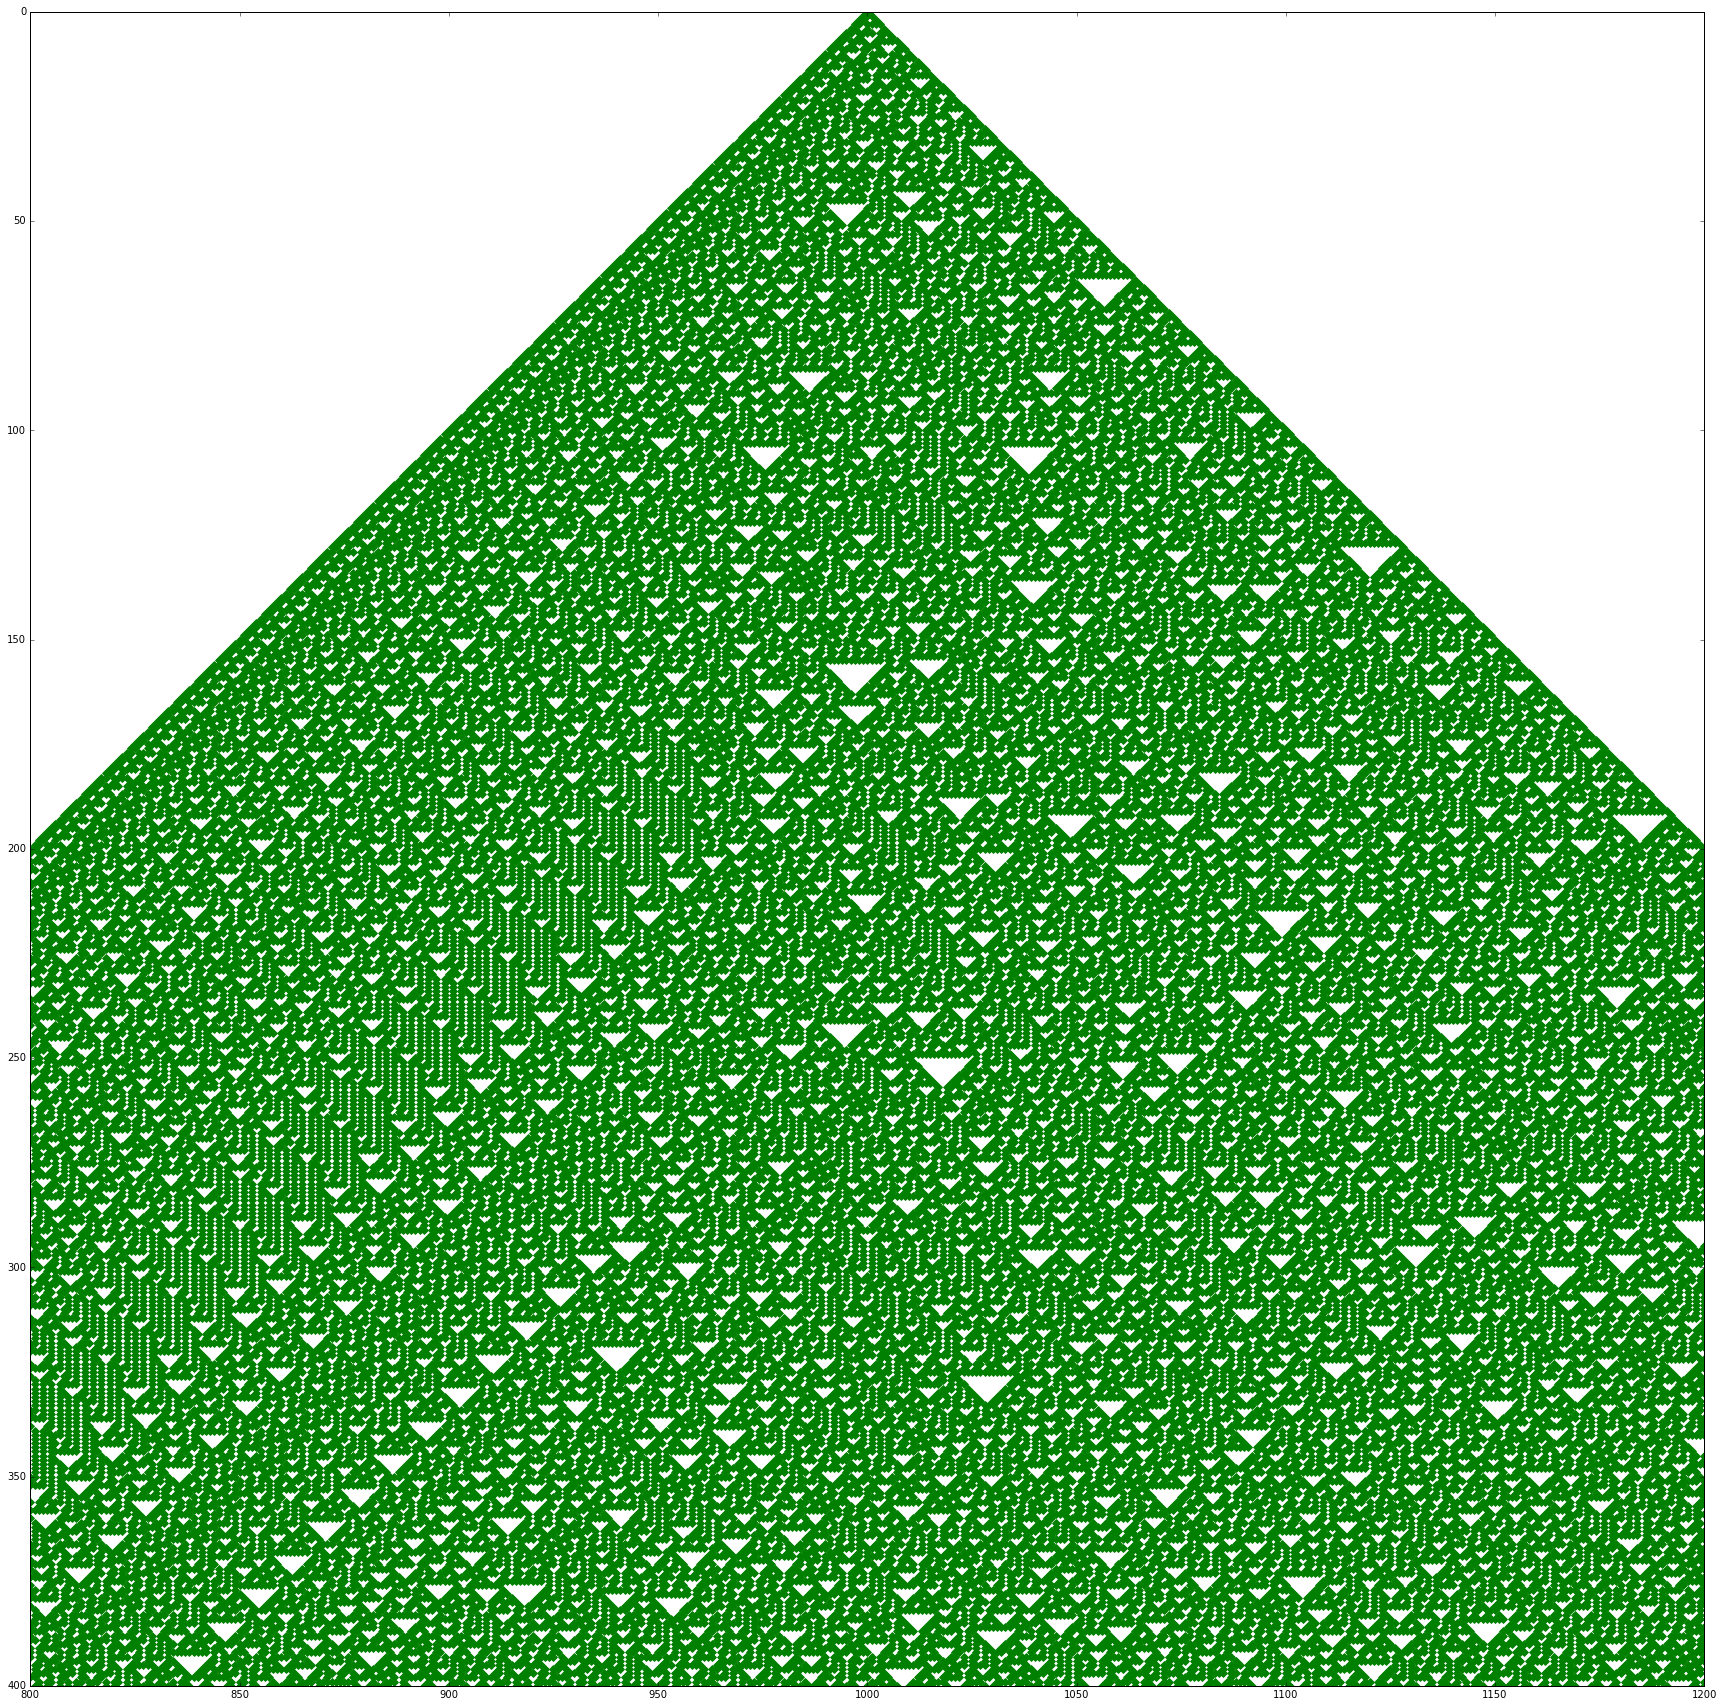

In [2]:
import numpy as np
import random as r

%pylab inline

ncells = 2000
ngens = 1000

rule = []

# Here is the rule!
# The result based on...
#           v       L M R
rule.append(0)    # 0 0 0
rule.append(1)    # 0 0 1
rule.append(1)    # 0 1 0
rule.append(0)    # 0 1 1
rule.append(0)    # 1 0 0
rule.append(1)    # 1 0 1
rule.append(1)    # 1 1 0
rule.append(0)    # 1 1 1

def RuleFromInteger(i):
    global rule
    rule[7] = i/128
    i -= rule[7]*128
    rule[6] = i/64
    i -= rule[6]*64
    rule[5] = i/32
    i -= rule[5]*32
    rule[4] = i/16
    i -= rule[4]*16
    rule[3] = i/8
    i -= rule[3]*8
    rule[2] = i/4
    i -= rule[2]*4
    rule[1] = i/2
    i -= rule[1]*2
    rule[0] = i

RuleFromInteger(30)
# RuleFromInteger(184) # Suggest: randomPattern = True
# RuleFromInteger(110)
# RuleFromInteger(90) # Meru Prastarah even/odd

ca0 = [0]*ncells
ca1 = [0]*ncells

randomPattern = False

if randomPattern:
    for i in range(ncells):
        ca0[i] = r.randint(0,1)
else:
    ca0[ncells/2] = 1

x=[]
y=[]

count = [0, 0, 0, 0, 0, 0, 0, 0]

for time in range(ngens):
    for space in range(ncells):
        if ca0[space] == 1: 
            x.append(space)
            y.append(time)
        if space == 0:
            ruleIndex = ca0[ncells - 1]*4 + ca0[0]*2 + ca0[1]
        elif space == ncells - 1:
            ruleIndex = ca0[ncells - 2]*4 + ca0[ncells - 1]*2 + ca0[0]
        else:
            ruleIndex = ca0[space-1]*4 + ca0[space]*2 + ca0[space+1]
        ca1[space] = rule[ruleIndex]
        count[ruleIndex] += 1
    for space in range(ncells):
        ca0[space] = ca1[space]

print len(x)
print count
print rule

figdim = 30
plt.figure(figsize=(figdim, figdim))

# zooming in and out on scatter plots is a bit of a 'regular Python' matplotlib thing.
# zooming here in a Jupyter notebook is a bit trickier
# a high density plot has dimensions 600 x 600 or so and the marker specs work fine like this:
# but to zoom in (say to 200 x 200) we need to modify the s value and possibly the marker string
# This page has marker symbols: http://matplotlib.org/api/markers_api.html
# The boolean 'fullplot' chooses which of these two options are used.
fullplot = True
if fullplot:
    plt.scatter(x,y,s=30, marker='D',color='g')
    plt.xlim([800., 1200.])
    plt.ylim([0., 400.])
else:
    plt.scatter(x,y,s=49, marker='s',color='g')
    plt.xlim([1400., 1600.])
    plt.ylim([800., 1000.])

# by flipping the y axis we have time increasing from top to bottom
plt.gca().invert_yaxis()